In [18]:
import os
import math
import datetime
import numpy as np
import pydicom
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
import pandas as pd

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [19]:
import numpy as np

file_path = "images/00000112_1.2.840.113619.2.8368.1234.25707428278.486545.npy"
img = np.load(file_path)

print("Loaded image shape:", img.shape)
print("First 10 values:", img.flatten()[:10])


Loaded image shape: (57, 101)
First 10 values: [0.0001848  0.00077001 0.00067761 0.00077001 0.00092402 0.00141682
 0.00107802 0.00129362 0.00806973 0.02192996]


In [20]:
# ---------------------------
# 1. Loading PET Series from a Modality Folder
# ---------------------------
def load_pet_series(modality_path):
    series_dict = defaultdict(list)
    # We now keep the entire list of DICOM slices for each series.
    if not os.path.exists(modality_path):
        print(f"❌ ERROR: Folder '{modality_path}' does not exist!")
        return {}
    
    files = os.listdir(modality_path)
    for file in files:
        file_path = os.path.join(modality_path, file)
        if os.path.isfile(file_path):
            try:
                ds = pydicom.dcmread(file_path)
                # Extract SeriesInstanceUID
                series_id = ds.get("SeriesInstanceUID", None)
                if series_id is None:
                    continue
                series_dict[series_id].append(ds)
            except Exception as e:
                print(f"❌ ERROR reading {file_path}: {e}")
    
    # Convert series_dict to stacked NumPy arrays and store full list of slices
    series_volumes = {}
    for series_id, ds_list in series_dict.items():
        ds_list.sort(key=lambda s: int(s.get("InstanceNumber", 0)))
        try:
            volume = np.stack([s.pixel_array for s in ds_list])
            series_volumes[series_id] = {"volume": volume, "metadata_list": ds_list}
        except Exception as e:
            print(f"❌ ERROR stacking slices for series {series_id}: {e}")
    return series_volumes

In [21]:
# ---------------------------
# 2. Resampling with SimpleITK
# ---------------------------
def resample_image(itk_image, new_spacing=[3.27, 3.27, 3.27]):
    """
    Resample an ITK image to a given isotropic spacing.

    Parameters:
        itk_image (SimpleITK.Image): Input ITK image.
        new_spacing (list): Desired voxel spacing [sx, sy, sz].

    Returns:
        SimpleITK.Image: Resampled image.
        
    """
    
    
    original_spacing = itk_image.GetSpacing()  # Old spacing
    original_size = itk_image.GetSize()  # Old shape (number of voxels)
    
    # Compute new shape using the correct formula
    new_size = [
        int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]
    
    print(f"Original Spacing: {original_spacing}")
    print(f"Original Size: {original_size}")
    print(f"New Spacing: {new_spacing}")
    print(f"Computed New Size: {new_size}")

    # Apply resampling
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetInterpolator(sitk.sitkLinear)

    resampled_image = resample.Execute(itk_image)
    return resampled_image


In [22]:
def parse_dicom_time(time_str):
    """
    Parses a DICOM time string in HHMMSS or HHMMSS.FFFFFF format.
    Handles missing values by returning None.
    """
    if not time_str:
        return None
    try:
        if '.' in time_str:
            return datetime.datetime.strptime(time_str, "%H%M%S.%f")
        else:
            return datetime.datetime.strptime(time_str, "%H%M%S")
    except Exception as e:
        print(f"Error parsing time '{time_str}': {e}")
        return None

def parse_dicom_datetime(datetime_str):
    """
    Parses a DICOM datetime string in YYYYMMDDHHMMSS.FFFFFF format.
    Returns a datetime object.
    """
    if not datetime_str:
        return None
    try:
        # We split off any fractional seconds for parsing.
        return datetime.datetime.strptime(datetime_str.split('.')[0], "%Y%m%d%H%M%S")
    except Exception as e:
        print(f"Error parsing datetime '{datetime_str}': {e}")
        return None

def calculate_decay_correction_factor(series_time, start_time, half_life):
    """
    Calculates the decay correction factor based on the time difference.
    
    Parameters:
      series_time (datetime): Time of series acquisition.
      start_time (datetime): Radiopharmaceutical injection time.
      half_life (float): Half-life in seconds.
      
    Returns:
      float: Decay correction factor.
    """
    if not series_time or not start_time or half_life <= 0:
        return 1  # Default correction factor if data is missing

    delta_t = (series_time - start_time).total_seconds()
    return math.exp(-math.log(2) * delta_t / half_life)

def extract_radiopharmaceutical_info(ds):
    """
    Extracts radiopharmaceutical metadata from the DICOM dataset.
    
    Returns:
      dict: Containing total_dose, half_life, and injection_time.
    """
    total_dose = None
    half_life = None
    injection_time = None

    if "RadiopharmaceuticalInformationSequence" in ds:
        radio_info = ds.RadiopharmaceuticalInformationSequence[0]  # Use the first entry

        total_dose = float(radio_info.get("RadionuclideTotalDose", 1))
        half_life = float(radio_info.get("RadionuclideHalfLife", 1))

        # Extract Injection Time from RadiopharmaceuticalStartDateTime or StartTime
        injection_time_str = radio_info.get("RadiopharmaceuticalStartDateTime", None)
        if injection_time_str:
            injection_time = parse_dicom_datetime(injection_time_str)
        else:
            injection_time_str = radio_info.get("RadiopharmaceuticalStartTime", None)
            injection_time = parse_dicom_time(injection_time_str)

    return {"total_dose": total_dose, "half_life": half_life, "injection_time": injection_time}

def extract_series_time(ds):
    """
    Extracts the series acquisition time from DICOM metadata.
    Tries to use SeriesDate/SeriesTime; if SeriesDate is missing or invalid,
    falls back to AcquisitionDate/AcquisitionTime.
    
    Returns:
      datetime: Parsed Series Time or None if unavailable.
    """
    series_time = None
    if "SeriesDate" in ds and "SeriesTime" in ds:
        series_date_str = ds.get("SeriesDate")
        series_time_str = ds.get("SeriesTime", "000000")
        # If the SeriesDate is "19000101" (a common default), try using AcquisitionDate instead.
        if series_date_str == "19000101" and "AcquisitionDate" in ds:
            series_date_str = ds.get("AcquisitionDate")
        series_time = parse_dicom_datetime(series_date_str + series_time_str)
    return series_time




In [23]:
def convert_to_suv(pixel_array, ds_list):
    print("---- SUV Conversion Debug Info ----")
    
    # Extract slice-specific Rescale Slope & Intercept
    rescale_slopes = np.array([float(ds.get("RescaleSlope", 1)) for ds in ds_list])
    rescale_intercepts = np.array([float(ds.get("RescaleIntercept", 0)) for ds in ds_list])
    print("Max Rescale Slope  :", rescale_slopes.max())
    print("Max Rescale Slope  :", rescale_slopes.mean())
    print("Max Rescale Intercept:", rescale_intercepts.max())
    
    total_dose = None
    half_life = None
    injection_time = None
    for ds in ds_list:
        if "RadiopharmaceuticalInformationSequence" in ds:
            radio_info = ds.RadiopharmaceuticalInformationSequence[0]
            total_dose = float(radio_info.get("RadionuclideTotalDose", 1))
            half_life = float(radio_info.get("RadionuclideHalfLife", 1))
            injection_time_str = radio_info.get("RadiopharmaceuticalStartDateTime", None)
            if injection_time_str:
                injection_time = parse_dicom_datetime(injection_time_str)
    
    print("Radionuclide Total Dose (Bq):", total_dose)
    print("Radionuclide Half-Life (s):", half_life)
    print("Injection Time:", injection_time)
    
    # Update: Combine SeriesDate and SeriesTime to get full acquisition datetime
    series_time = None
    if "SeriesDate" in ds_list[0] and "SeriesTime" in ds_list[0]:
        series_date_str = ds_list[0].get("SeriesDate")
        series_time_str = ds_list[0].get("SeriesTime", "000000")
        series_time = parse_dicom_datetime(series_date_str + series_time_str)
    print("Series Time:", series_time)
    
    patient_weight = float(ds_list[0].get("PatientWeight", 1))
    print("Patient Weight (kg):", patient_weight)
    
    if total_dose is None or total_dose <= 0:
        print("WARNING: Radionuclide Total Dose is zero or missing! Setting to 1 to avoid division by zero.")
        total_dose = 1
    
    decay_factor = 1
    if series_time and injection_time and half_life > 0:
        delta_t = (series_time - injection_time).total_seconds()
        decay_factor = math.exp(-math.log(2) * delta_t / half_life)
    print("Decay Correction Factor:", decay_factor)
    
    activity_concentration = (pixel_array * rescale_slopes[:, None, None]) + rescale_intercepts[:, None, None]
    print("Max activity concentration (Bq/ml):", np.max(activity_concentration))
    
    corrected_dose = total_dose * decay_factor
    print("Corrected Dose (Bq):", corrected_dose)
    
    suv_image = (activity_concentration * patient_weight * 1000) / corrected_dose
    print("Max SUV value calculated:", np.max(suv_image))
    print("------------------------------------")
    
    return suv_image

Script suivant est inutile vue que on touche pas au decay factor du tt au final

In [24]:
# def convert_to_suv(pixel_array, ds_list):
#     print("---- SUV Conversion Debug Info ----")
    
#     # Extract slice-specific Rescale Slope & Intercept.
#     rescale_slopes = np.array([float(ds.get("RescaleSlope", 1)) for ds in ds_list])
#     rescale_intercepts = np.array([float(ds.get("RescaleIntercept", 0)) for ds in ds_list])
#     print("Max Rescale Slope  :", rescale_slopes.max())
#     print("Mean Rescale Slope  :", rescale_slopes.mean())
#     print("Max Rescale Intercept:", rescale_intercepts.max())
    
#     total_dose = None
#     half_life = None
#     injection_time = None
#     for ds in ds_list:
#         if "RadiopharmaceuticalInformationSequence" in ds:
#             radio_info = ds.RadiopharmaceuticalInformationSequence[0]
#             total_dose = float(radio_info.get("RadionuclideTotalDose", 1))
#             half_life = float(radio_info.get("RadionuclideHalfLife", 1))
#             injection_time_str = radio_info.get("RadiopharmaceuticalStartDateTime", None)
#             if injection_time_str:
#                 injection_time = parse_dicom_datetime(injection_time_str)
#             break  # assume same for all slices
#     print("Radionuclide Total Dose (Bq):", total_dose)
#     print("Radionuclide Half-Life (s):", half_life)
#     print("Injection Time:", injection_time)
    
#     # Combine SeriesDate and SeriesTime to get full acquisition datetime.
#     series_time = None
#     if "SeriesDate" in ds_list[0] and "SeriesTime" in ds_list[0]:
#         series_date_str = ds_list[0].get("SeriesDate")
#         series_time_str = ds_list[0].get("SeriesTime", "000000")
#         series_time = parse_dicom_datetime(series_date_str + series_time_str)
#     print("Series Time:", series_time)
    
#     patient_weight = float(ds_list[0].get("PatientWeight", 1))
#     print("Patient Weight (kg):", patient_weight)
    
#     if total_dose is None or total_dose <= 0:
#         print("WARNING: Radionuclide Total Dose is zero or missing! Setting to 1 to avoid division by zero.")
#         total_dose = 1
    
#     # Compute per-slice decay factors.
#     decay_factors = []
#     for ds in ds_list:
#         slice_decay = None
#         # First, try to retrieve the per-slice "DecayFactor" attribute.
#         if "DecayFactor" in ds:
#             try:
#                 slice_decay = float(ds.get("DecayFactor"))
#             except Exception as e:
#                 print("Error retrieving DecayFactor for slice:", e)
#         # Second, check CorrectedImage attribute for "DCLA".
#         if slice_decay is None:
#             corrected_image_attr = ds.get("CorrectedImage", "")
#             if "DCLA" in corrected_image_attr.upper():
#                 slice_decay = 1.07498
#         # Third, if still not available, compute using slice-specific acquisition time.
#         if slice_decay is None:
#             if "SeriesDate" in ds and "SeriesTime" in ds:
#                 series_date_str = ds.get("SeriesDate")
#                 series_time_str = ds.get("SeriesTime", "000000")
#                 slice_series_time = parse_dicom_datetime(series_date_str + series_time_str)
#             else:
#                 # Fall back to the first slice's series time.
#                 first_ds = ds_list[0]
#                 series_date_str = first_ds.get("SeriesDate")
#                 series_time_str = first_ds.get("SeriesTime", "000000")
#                 slice_series_time = parse_dicom_datetime(series_date_str + series_time_str)
#             if slice_series_time and injection_time and half_life > 0:
#                 slice_decay = calculate_decay_correction_factor(slice_series_time, injection_time, half_life)
#             else:
#                 slice_decay = 1
#         decay_factors.append(slice_decay)
    
#     decay_factors = np.array(decay_factors)  # shape: (n_slices,)
#     print("Mean Decay Factor:", np.mean(decay_factors))
    
#     activity_concentration = (pixel_array * rescale_slopes[:, None, None]) + rescale_intercepts[:, None, None]
#     print("Max activity concentration (Bq/ml):", np.max(activity_concentration))
    
#     # Compute corrected dose per slice (broadcast decay_factors over each slice).
#     corrected_dose = total_dose * decay_factors[:, None, None]
#     print("Sample Corrected Dose (Bq) per slice, max:", np.max(corrected_dose))
    
#     suv_image = (activity_concentration * patient_weight * 1000) / corrected_dose
#     print("Max SUV value calculated:", np.max(suv_image))
#     print("------------------------------------")
    
#     return suv_image


In [25]:
def generate_mip(volume, view="sagittal", clip_min=0, clip_max=30):
    """
    Generate a Maximum Intensity Projection (MIP) from a 3D PET SUV image.
    
    Parameters:
        volume (np.ndarray): 3D PET SUV image.
        view (str): 'axial', 'coronal', or 'sagittal'.
        clip_min (float): Minimum value for clipping (default: 0 SUV).
        clip_max (float): Maximum value for clipping (default: 30 SUV).

    Returns:
        np.ndarray: Normalized MIP image.
    """
    if view == "axial":
        mip = np.max(volume, axis=0)  # Max projection along Z-axis (axial)
    elif view == "coronal":
        mip = np.max(volume, axis=1)  # Max projection along Y-axis (coronal)
    elif view == "sagittal":
        mip = np.max(volume, axis=2)  # Max projection along X-axis (sagittal)
    else:
        raise ValueError("Invalid view. Choose from 'axial', 'coronal', or 'sagittal'.")

    # Clip values
    mip = np.clip(mip, clip_min, clip_max)
    
    # # Apply Min-Max Normalization
    # mip_normalized = np.clip(axial_mip, clip_min, clip_max)
    # mip_normalized = (mip_normalized - clip_min) / (clip_max - clip_min)
    #BEFORE OR AFTER GENERATING THE MIP, I WOULD SAY AFTER BUT MIGHT NOT CHANGE MUCH
    
    return mip


In [26]:
# ---------------------------
# 4. Visualization Functions
# ---------------------------
def visualize_volume_3d(volume, level=None):
    """
    Visualize a 3D volume using the marching cubes algorithm.
    """
    if level is None:
        level = np.mean(volume)
        print(f"No level provided. Using mean intensity: {level:.2f}")
    
    verts, faces, normals, values = measure.marching_cubes(volume, level=level)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.45, 0.45, 0.75])
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, volume.shape[0])
    ax.set_ylim(0, volume.shape[1])
    ax.set_zlim(0, volume.shape[2])
    ax.set_title("3D Volume Rendering")
    plt.tight_layout()
    plt.show()

def visualize_slice(volume, slice_index=None, axis=0):
    """
    Visualize a 2D slice from a 3D volume.
    """
    if slice_index is None:
        slice_index = volume.shape[axis] // 2

    if axis == 0:
        slice_data = volume[slice_index, :, :]
    elif axis == 1:
        slice_data = volume[:, slice_index, :]
    elif axis == 2:
        slice_data = volume[:, :, slice_index]
    else:
        raise ValueError("Axis must be 0, 1, or 2.")
    
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_data, cmap='gray')
    plt.title(f"2D Slice (axis={axis}, index={slice_index})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_mip_axial(image):
    """
    Displays the axial MIP (2D array) alongside a histogram of its pixel values.
    Assumes 'image' is already your MIP in SUV units (or scaled to reflect SUV).
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # -----------------------------
    # Subplot 1: Show the MIP image
    # -----------------------------
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("MIP View")
    axs[0].axis('off')

    # -----------------------------
    # Subplot 2: Histogram of pixel/SUV values
    # -----------------------------
    # Flatten the MIP image into 1D for the histogram
    valid_pixels = image.ravel()
    
    # (Optional) Filter out pure zeros if you only want the distribution of non-zero SUVs:
    #valid_pixels = valid_pixels[valid_pixels > 0]

    axs[1].hist(valid_pixels, bins=50, color='blue', alpha=0.7)
    axs[1].set_title("SUV Distribution")
    axs[1].set_xlabel("SUV Value")
    axs[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [27]:
def get_bbox(img, threshold=0.02):
    """
    Extracts the bounding box around the relevant non-zero pixels in the image.
    Uses a threshold to exclude near-zero background pixels.
    
    Parameters:
        img (np.ndarray): Input 2D MIP image.
        threshold (float): Minimum value to consider as "non-background".
        
    Returns:
        np.ndarray: Cropped image containing only the relevant region.
    """
    mask = img > threshold  # Create a mask where pixel values exceed threshold
    
    if np.any(mask):  # If there are non-background pixels
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        return img[rmin:rmax+1, cmin:cmax+1]  # +1 to include last pixel
    else:
        return img  # Return original if no valid region found


In [28]:
def get_bbox_percentile(img, lower_percentile=5):
    """
    Extracts the bounding box by removing the lowest X% of pixel intensities.
    
    Parameters:
        img (np.ndarray): Input 2D MIP image.
        lower_percentile (float): Percentile below which pixels are considered background.
    
    Returns:
        np.ndarray: Cropped image.
    """
    threshold = np.percentile(img, lower_percentile)  # Compute a dynamic threshold
    return get_bbox(img, threshold)


Version avec Z normalization comme dans le paper

In [29]:
# def preprocess_image(image, new_range=(0, 30)):
#     """
#     Prétraite l'image pour la CNN :
#       1. Ramène linéairement les valeurs de l'image dans l'intervalle new_range.
#       2. Applique la Z-normalisation (score Z).

#     Parameters:
#         image (np.ndarray): image en SUV (ex : MIP).
#         new_range (tuple): intervalle cible, ici (0, 30).
        
#     Returns:
#         np.ndarray: image prétraitée prête pour la CNN.
#     """
#     # 1. Mapping linéaire vers [new_range[0], new_range[1]]
#     current_min = np.min(image)
#     current_max = np.max(image)
#     mapped = (image - current_min) / (current_max - current_min) * (new_range[1] - new_range[0]) + new_range[0]
#     #inutile en soit, le but c'est de clipper les valeurs a 30, non pas de les etirer mais ici pour simuler valeur attendue
    
#     # 2. Z-normalisation (score Z)
#     mean_val = np.mean(mapped)
#     std_val = np.std(mapped)
#     if std_val > 0:
#         z_normalized = (mapped - mean_val) / std_val
#     else:
#         z_normalized = mapped - mean_val  # Au cas où std_val == 0
    
#     return z_normalized


In [30]:
def normalize_image(img):
    """
    Normalize the image pixel values to the [0, 1] range.

    Parameters:
        img (np.ndarray): Input image (e.g., MIP image in SUV units).

    Returns:
        np.ndarray: Normalized image with values between 0 and 1.
    """
    img_min = np.min(img)
    img_max = np.max(img)
    
    # Avoid division by zero in case img_min == img_max
    if img_max > img_min:
        normalized = (img - img_min) / (img_max - img_min)
    else:
        normalized = np.zeros_like(img)  # If the image is uniform, return a zero matrix
    
    return normalized


In [ ]:

def random_positioning(image, canvas_size=200):
    """
    Places the PET MIP image randomly within a larger canvas (e.g., 310×310).
    
    Parameters:
    -----------
    image : np.ndarray or torch.Tensor
        The input PET MIP image (2D).
    canvas_size : int
        The size of the larger square canvas, default = 310.
        
    Returns:
    --------
    positioned : torch.Tensor (shape: [canvas_size, canvas_size])
        The 2D image placed randomly on a black (zero) background.
    """
    if isinstance(image, np.ndarray):
        image_tensor = torch.tensor(image, dtype=torch.float32)
    else:
        image_tensor = image.clone()  # ensure we work on a copy
    
    # Current image height and width
    h, w = image_tensor.shape
    
    # Create an empty canvas: (canvas_size, canvas_size)
    canvas = torch.zeros((canvas_size, canvas_size), dtype=torch.float32)
    
    # Compute max random shifts so that the entire image stays within the canvas
    max_y_shift = canvas_size - h
    max_x_shift = canvas_size - w
    
    # In case the image is as large or larger than the canvas,
    # clamp to avoid negative random range. (Should normally not happen if MIP < 310.)
    max_y_shift = max(max_y_shift, 0)
    max_x_shift = max(max_x_shift, 0)
    
    # Sample random shifts
    shift_y = random.randint(0, max_y_shift)
    shift_x = random.randint(0, max_x_shift)
    
    # Place the original image into the canvas
    canvas[shift_y:shift_y + h, shift_x:shift_x + w] = image_tensor
    
    return canvas


In [63]:
def augment_image(image, 
                  final_canvas_size=200, 
                  rotate_range=15, 
                  scale_range=(0.85, 1.2),
                  normalize_01=True):
    """
    Applies multiple augmentations to a single-channel PET MIP image.
    
    Parameters:
    -----------
    image : np.ndarray
        Grayscale PET MIP image.
    final_canvas_size : int
        Size of the canvas to place the image in, typically 310×310.
    rotate_range : float
        Rotation angle range (± value).
    scale_range : tuple of floats
        Range for random intensity scaling (SUV scaling).
    normalize_01 : bool
        If True, normalize image into [0, 1] before augmentations.
        
    Returns:
    --------
    augmented : np.ndarray
        Augmented image as a 2D array (shape: [final_canvas_size, final_canvas_size]).
    """
    # 1) Convert to PyTorch tensor
    image_tensor = torch.tensor(image, dtype=torch.float32)

    # # 2) Optionally normalize image to [0, 1] (only if min < max to avoid /0)
    # if normalize_01 and (image_tensor.max() > image_tensor.min()):
    #     image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
    # else:
    #     # Just clamp to [0,1] if it has negative or very large values
    #     image_tensor = torch.clamp(image_tensor, 0.0, 1.0)
        
        #MAIS NORMALMEENT ON LE FAIT DEJA AVANT AUGMENTATION ?

    # 3) Place onto a larger canvas at a random position
    positioned = random_positioning(image_tensor, canvas_size=final_canvas_size)

    # 4) Convert to PIL for flips & rotations
    image_pil = TF.to_pil_image(positioned.unsqueeze(0))  # Make it 1-channel PIL Image

    # 5) Random horizontal flip
    if random.random() > 0.7:
        image_pil = TF.hflip(image_pil)
    # 6) Random vertical flip
    if random.random() > 0.3:
        image_pil = TF.vflip(image_pil)

    # 7) Random rotation
    angle = random.uniform(-rotate_range, rotate_range)
    image_pil = TF.rotate(image_pil, angle)

    # 8) Convert back to Tensor
    augmented_tensor = TF.to_tensor(image_pil).squeeze(0)  # shape: [H, W]

    # 9) Apply random SUV scaling (intensity scaling)
    scale_factor = random.uniform(scale_range[0], scale_range[1])
    augmented_tensor *= scale_factor

    # # 10) (Optional) Add Gaussian noise
    # noise_std = random.uniform(0.002, 0.01)
    # noise = torch.normal(0, noise_std, size=augmented_tensor.shape)
    # augmented_tensor = torch.clamp(augmented_tensor + noise, 0, 1)

    return augmented_tensor.numpy()

In [64]:
def visualize_augmentations(image, n_samples=5):
    """
    Applies `augment_image` multiple times and visualizes the augmented results.

    Parameters:
    -----------
    image : np.ndarray
        Input PET MIP image.
    n_samples : int
        Number of augmented images to generate.
    """
    fig, axes = plt.subplots(1, n_samples + 1, figsize=(15, 5))

    # Display the original image
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original MIP")
    axes[0].axis("off")

    # Generate and display augmented images
    for i in range(n_samples):
        augmented = augment_image(image)
        axes[i + 1].imshow(augmented, cmap="gray")
        axes[i + 1].set_title(f"Augmented {i+1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


In [34]:
# for elem in ref_ds:
#     print(f"{elem.keyword}: {elem.value}")


In [35]:
# def preprocess_pet_series(series_data, new_spacing=[4,4,4], roi_slice_range=(200,250), bbox_threshold=0.019):
#     """
#     Applies the full preprocessing pipeline to a single PET series.
    
#     Parameters:
#       series_data (dict): Dictionary with keys "volume" and "metadata" from a PET series.
#       new_spacing (list): Target spacing for resampling.
#       roi_slice_range (tuple): Range of slices (start, end) to extract ROI.
#       bbox_threshold (float): Threshold for bounding box extraction.
      
#     Returns:
#       final_image: Processed MIP image after normalization and bounding box extraction.
#       suv_volume: The full SUV-converted volume.
#     """
    
#     # Extract the raw volume and reference metadata
#     raw_volume = series_data["volume"]
#     ds_list = series_data[0]["metadata_list"]  # List of DICOM slices



#     suv_volume = convert_to_suv(raw_volume, ds_list)
    
#     # Extract pixel spacing and slice thickness from DICOM metadata
#     pixel_spacing = ds_list[0].PixelSpacing  # (X, Y) spacing in mm
#     slice_thickness = ds_list[0].SliceThickness  # Z spacing in mm

#     # Convert raw NumPy volume to ITK image and set spacing
#     itk_image = sitk.GetImageFromArray(raw_volume)
#     itk_image.SetSpacing((float(pixel_spacing[0]), float(pixel_spacing[1]), float(slice_thickness)))

#     # Resample the image
#     itk_image_resampled = resample_image(itk_image, new_spacing=new_spacing)
#     volume_resampled = sitk.GetArrayFromImage(itk_image_resampled)

#     # Convert to SUV using the provided conversion function
#     suv_volume = convert_to_suv(volume_resampled, ds_list)

#     # Extract a region of interest (ROI) from the SUV volume
#     roi_volume = suv_volume[roi_slice_range[0]:roi_slice_range[1], :, :]

#     # Generate a Maximum Intensity Projection (MIP) image from the ROI
#     mip_image = generate_mip(roi_volume, clip_min=0, clip_max=30)

#     # Normalize the MIP image
#     norm_mip = normalize_image(mip_image)

#     # Extract the bounding box around the MIP (may need to adjust threshold if background is not exactly zero)
#     final_image = get_bbox_percentile(norm_mip, 85)

#     return final_image, suv_volume



In [62]:
def preprocess_pet_series(series_data, new_spacing=[4, 4, 4], roi_slice_range=(30, 230), bbox_percentile=90):
    """
    Applies the full preprocessing pipeline to a single PET series.
    
    Parameters:
      series_data (dict): Dictionary with keys "volume" and "metadata_list" from a PET series.
      new_spacing (list): Target spacing for resampling (e.g., [4, 4, 4]).
      roi_slice_range (tuple): Range of slices (start, end) to extract ROI from the resampled volume.
      bbox_percentile (float): Lower percentile for bounding box extraction.
      
    Returns:
      dict: Containing:
            - "mip_coronal": Processed coronal MIP image after normalization and bounding box extraction.
            - "mip_sagittal": Processed sagittal MIP image after normalization and bounding box extraction.
            - "suv_volume_resampled": The full SUV-converted, resampled volume.
    """
    # Extract the raw volume and list of DICOM slices.
    raw_volume = series_data["volume"]
    ds_list = series_data["metadata_list"]

    # ---------------------------
    # Step A: Convert Raw Volume to SUV Volume
    # ---------------------------
    suv_volume = convert_to_suv(raw_volume, ds_list)
    print("SUV volume shape:", suv_volume.shape)

    # ---------------------------
    # Extract Pixel Spacing and Slice Thickness from DICOM metadata.
    # ---------------------------
    pixel_spacing = ds_list[0].PixelSpacing  # (X, Y) spacing in mm
    slice_thickness = ds_list[0].SliceThickness  # Z spacing in mm

    # ---------------------------
    # Step B: Resample the SUV Volume
    # ---------------------------
    itk_image = sitk.GetImageFromArray(suv_volume)
    itk_image.SetSpacing((float(pixel_spacing[0]), float(pixel_spacing[1]), float(slice_thickness)))
    itk_image_resampled = resample_image(itk_image, new_spacing=new_spacing)
    suv_volume_resampled = sitk.GetArrayFromImage(itk_image_resampled)
    print("Resampled Size:", suv_volume_resampled.shape)

    # ---------------------------
    # Step C: Crop the Volume to the ROI.
    # ---------------------------
    roi_volume = suv_volume_resampled[roi_slice_range[0]:roi_slice_range[1], :, :]
    
    # ---------------------------
    # Step D: Generate MIP Images.
    # ---------------------------
    mip_coronal = generate_mip(roi_volume, view="coronal", clip_min=0, clip_max=30)
    mip_sagittal = generate_mip(roi_volume, view="sagittal", clip_min=0, clip_max=30)

    # ---------------------------
    # Step E: Normalize and Crop the MIP Images.
    # ---------------------------
    norm_coronal = normalize_image(mip_coronal)
    norm_sagittal = normalize_image(mip_sagittal)

    bbox_coronal = get_bbox_percentile(norm_coronal, lower_percentile=bbox_percentile)
    bbox_sagittal = get_bbox_percentile(norm_sagittal, lower_percentile=bbox_percentile)

    images = {
        "mip_coronal": bbox_coronal,
        "mip_sagittal": bbox_sagittal,
        "suv_volume": suv_volume_resampled
    }
    return images


Observe beaucoup de low level noise malgré le bounding box, defficile de definir le treshold qui est le bon, 80 percentile seems ok to me for now

In [61]:
# ---------------------------
# 5. Full PET Preprocessing Pipeline on a single PET Folder
# ---------------------------
# Specify the path to your PET modality folder.
pet_modality_path = r"C:\Users\alime\Dropbox (AMC)\Mon PC (DESKTOP-RG9FHVT)\Desktop\Deauville\Deauville_DeepLearning\2025-02__Studies\DOE^JANE_ANON40815_PT_2025-02-12_091445_PET.FDG.corps.entier_PETAC.QC800.TF_n669__00000"

# Load the PET series (grouped by SeriesInstanceUID)
pet_series = load_pet_series(pet_modality_path)
print("Available PET series:")
for series_id in pet_series:
    vol_shape = pet_series[series_id]["volume"].shape
    print(f"  Series UID: {series_id} with volume shape: {vol_shape}")

# For this example, select the first series available.
selected_series_id = list(pet_series.keys())[0]
raw_volume = pet_series[selected_series_id]["volume"]
ds_list = pet_series[selected_series_id]["metadata_list"]  # List of DICOM slices

# ---------------------------
# Step A: Convert to SUV Before Resampling
# ---------------------------
suv_volume = convert_to_suv(raw_volume, ds_list)
print("SUV volume shape:", suv_volume.shape)

# Assuming suv_volume is your final SUV-converted volume
mean_suv = np.mean(suv_volume)
max_suv = np.max(suv_volume)
min_suv = np.min(suv_volume)

print("SUV Statistics:")
print("  Mean SUV:", mean_suv)
print("  Max SUV:", max_suv)
print("  Min SUV:", min_suv)

# ---------------------------
# Extract and Print Original Resolution Before Resampling
# ---------------------------
# Extract pixel spacing and slice thickness from DICOM metadata
pixel_spacing = ds_list[0].PixelSpacing  # (X, Y) spacing in mm
slice_thickness = ds_list[0].SliceThickness  # Z spacing in mm

# ---------------------------
# Step B: Resample the SUV Volume
# ---------------------------
# Convert the SUV NumPy volume to an ITK image
itk_image = sitk.GetImageFromArray(suv_volume)

# Set the correct spacing before resampling
itk_image.SetSpacing((pixel_spacing[0], pixel_spacing[1], slice_thickness))

# Resample the image to isotropic spacing (4mm³ voxels)
itk_image_resampled = resample_image(itk_image, new_spacing=[4, 4, 4])
suv_volume_resampled = sitk.GetArrayFromImage(itk_image_resampled)

print("Resampled Spacing:", [4, 4, 4])
print("Resampled Size:", suv_volume_resampled.shape)

KeyboardInterrupt: 

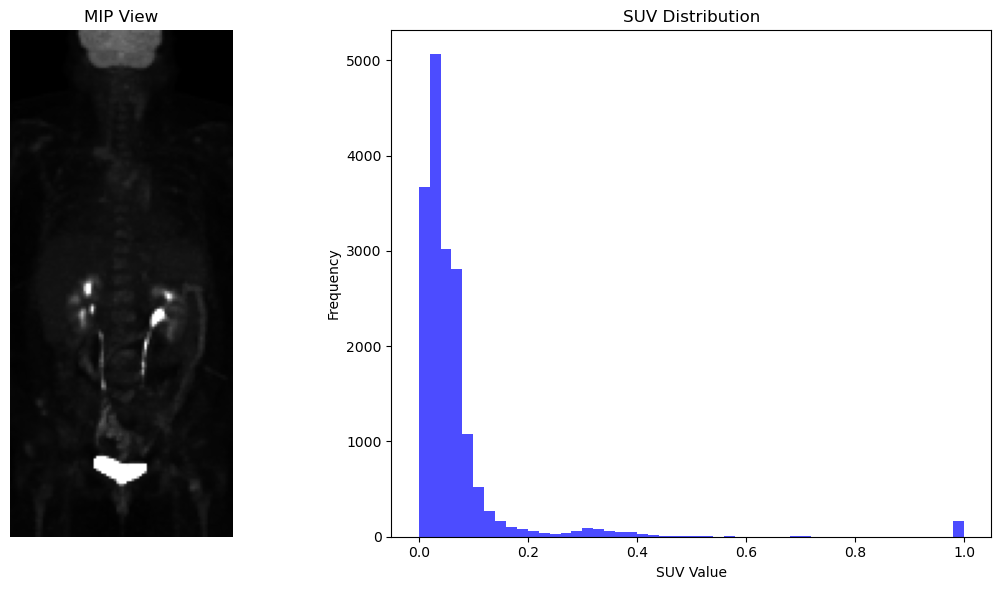

(200, 88)


In [49]:
# ---------------------------
# Step C: Generate and Visualize MIP Images
# ---------------------------
# Suppose you only want slices 200..400 (inclusive of 400).
roi_volume = suv_volume_resampled[30:230:,:, :]
#défini le cropping verticallement
mip_image = generate_mip(roi_volume, view="coronal", clip_min=0, clip_max=40)
norm_mip = normalize_image(mip_image)

final_image = get_bbox_percentile(norm_mip, lower_percentile=80)
#défini le cropping horizontallement
visualize_mip_axial(final_image)
print(final_image.shape)




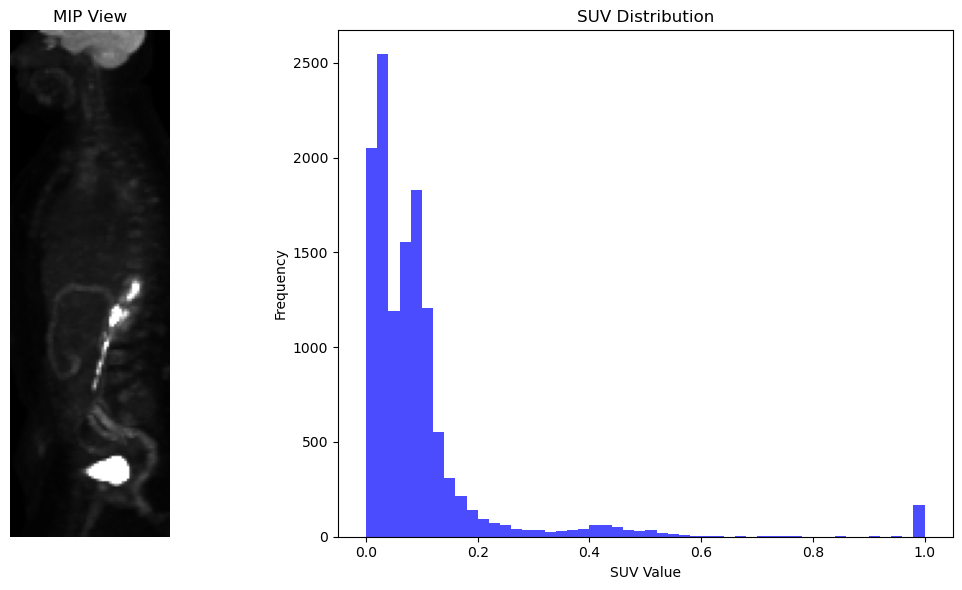

(200, 63)


In [68]:

# ---------------------------
# Step C: Generate and Visualize MIP Images
# ---------------------------
# Suppose you only want slices 200..400 (inclusive of 400).
roi_volume = suv_volume_resampled[30:230, :, :]
mip_image = generate_mip(roi_volume, view="sagittal", clip_min=0, clip_max=30)
norm_mip = normalize_image(mip_image)

final_image = get_bbox_percentile(norm_mip, lower_percentile=90)
visualize_mip_axial(final_image)
print(final_image.shape)






In [ ]:
images = preprocess_pet_series(pet_series[selected_series_id])

---- SUV Conversion Debug Info ----
Max Rescale Slope  : 9.04428
Max Rescale Slope  : 0.4930678983258595
Max Rescale Intercept: 0.0
Radionuclide Total Dose (Bq): 202190000.0
Radionuclide Half-Life (s): 6586.2001953125
Injection Time: 2025-02-12 08:15:00
Series Time: 2025-02-12 09:19:00
Patient Weight (kg): 102.0
Decay Correction Factor: 0.6675569187849013
Max activity concentration (Bq/ml): 296353.92276000004
Corrected Dose (Bq): 134973333.4091192
Max SUV value calculated: 223.95609086644745
------------------------------------
SUV volume shape: (669, 256, 256)
Original Spacing: (2.734375, 2.734375, 2.79)
Original Size: (256, 256, 669)
New Spacing: [4, 4, 4]
Computed New Size: [175, 175, 467]
Resampled Size: (467, 175, 175)


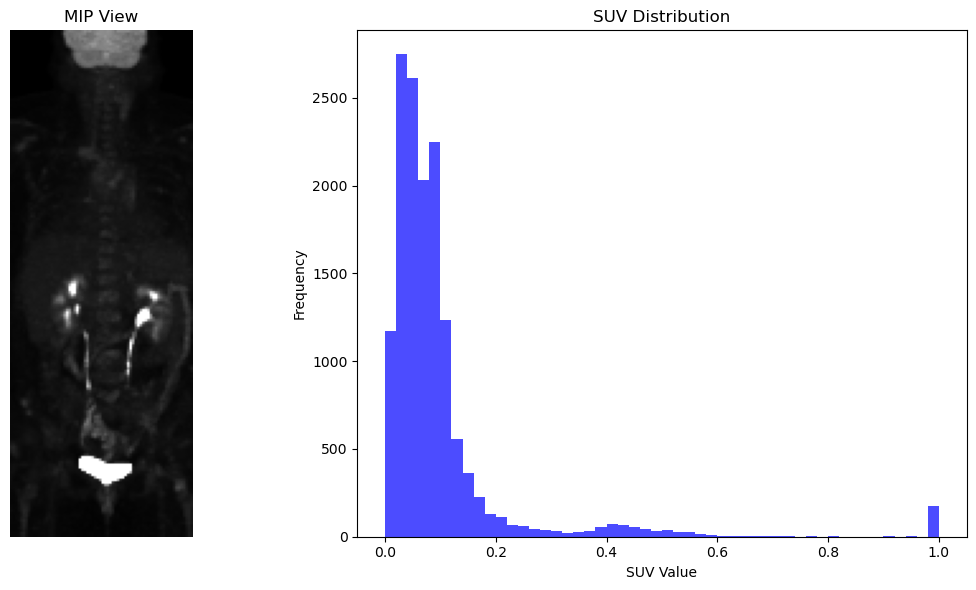

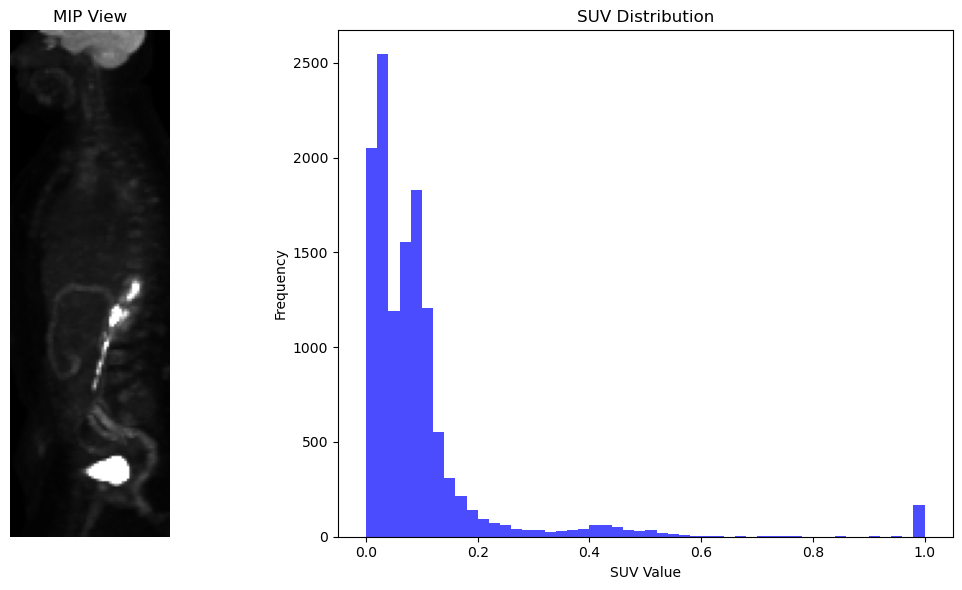

In [41]:
visualize_mip_axial(images["mip_coronal"])
visualize_mip_axial(images["mip_sagittal"])
# visualize_volume_3d(images["suv_volume"])


Notice presence of Outlier that give MAx SUV very high

We need to clip from TIGHT to mid skull genre : Done grace a la selection manuel des slices, a voir si le nombre de slices et la VIEW qu'ils représentent est constante sur toutes les images.

Still need to select sice for ROI ? Or might not be necesseray cause visually donest change anyhting as MIP already discard zone of non interest, its more usefull in the case of superposition of zone of interest so for axial view, but for coronal and sagittal doesnt seems to change a lot 

In [42]:
# # ---------------------------
# # Additional Visualization: 3D and 2D Slices
# # ---------------------------
# # Visualize a 3D rendering (isosurface extraction)
# visualize_volume_3d(raw_volume, level=None)


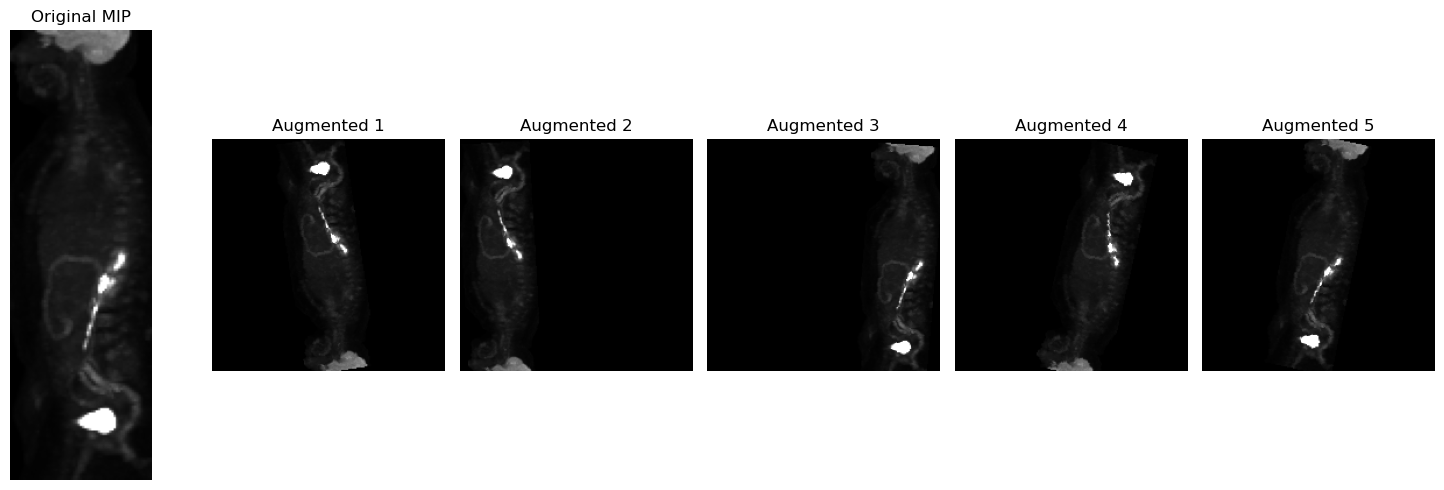

In [ ]:
augmented = augment_image(final_image, final_canvas_size=200)

visualize_augmentations(final_image, n_samples=5)


Ok tout fonctionne sauf le fact que l'augmentation ne s'applique sur un mip a la fois là.

In [44]:

# class PETDataset(Dataset):
#     def __init__(self, images, labels=None, transform=None):
#         """
#         Args:
#             images (list or np.ndarray): A list (or array) of images (each a numpy array).
#             labels (list, optional): Corresponding labels if available.
#             transform (callable, optional): Optional transform to be applied on an image.
#         """
#         self.images = images
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)
    
#     def __getitem__(self, idx):
#         # Get image as a NumPy array from your preprocessed pipeline.
#         img = self.images[idx]
        
#         # Convert to a PyTorch tensor (dtype float32)
#         img_tensor = torch.tensor(img, dtype=torch.float32)
        
#         # If the image is 2D (H, W), add a channel dimension to get (1, H, W)
#         if img_tensor.ndim == 2:
#             img_tensor = img_tensor.unsqueeze(0)
            
            
#         #transforms.ToTensor
        
#         # If you have any transform defined, apply it
#         if self.transform:
#             img_tensor = self.transform(img_tensor)
        
#         if self.labels is not None:
#             return img_tensor, self.labels[idx]
#         else:
#             return img_tensor

# # Example usage:
# # Assume you have a list of preprocessed augmented images (e.g., from your visualize_augmentations function)
# preprocessed_images = []  # You would collect your final images here (each should be a numpy array of shape (H, W))

# # For demonstration, let’s say we have 100 images in preprocessed_images
# # (In practice, you may generate them or load them from disk.)
# for _ in range(100):
#     # For example, using your augment_image function on mip_image (already preprocessed)
#     augmented_img = augment_image(mip_image, final_canvas_size=200)
#     preprocessed_images.append(augmented_img)

# # Create a dataset and a DataLoader
# dataset = PETDataset(preprocessed_images)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# # Now, when iterating over the dataloader, each batch will have shape:
# # (batch_size, channels, height, width), e.g., (16, 1, 200, 200)
# for batch in dataloader:
#     # If no labels are provided, batch is just images
#     images = batch  # shape: [16, 1, 200, 200]
#     # You can now feed 'images' into your CNN.
#     print(images.shape)
#     break
